In [1]:
import numpy as np 
import pandas as pd 
import os
import math
import optuna
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, RandomizedSearchCV


# Imports for Deep Learning
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential


# ensure consistency across runs
from numpy.random import seed
seed(1)

#set_random_seed(2)

# Imports to view data
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random


2024-06-24 12:43:28.393811: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 12:43:28.393921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 12:43:28.536475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = pd.read_csv("/Dataset/Train.csv")
test = pd.read_csv('/Dataset/Test.csv')
sub = pd.read_csv("/Dataset/SampleSubmission.csv")
train

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.000
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.000
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.000
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,31-12-21,X9897,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,39.750
86580,ID_UDQIEE,31-12-21,X9928,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.125
86581,ID_ENDUPX,31-12-21,X9969,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,28.325
86582,ID_3ZBA6C,31-12-21,X9993,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,21.250


In [3]:
print(train.shape)
train.describe()

(86584, 14)


,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


# Simple EDA

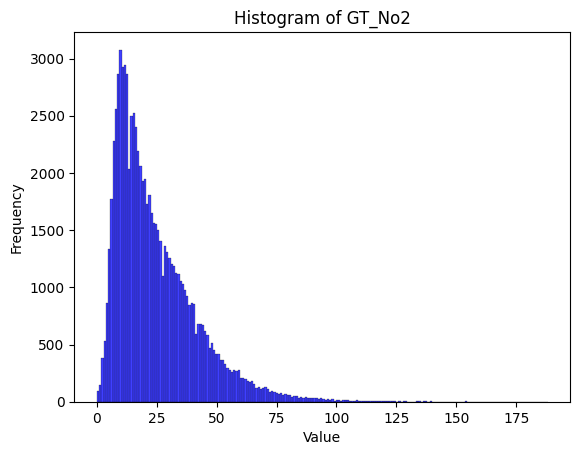

In [4]:
sns.histplot(train["GT_NO2"], bins=202, kde=False, color='blue', edgecolor='black')

# Customize labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of GT_No2')

# Display the plot
plt.show()

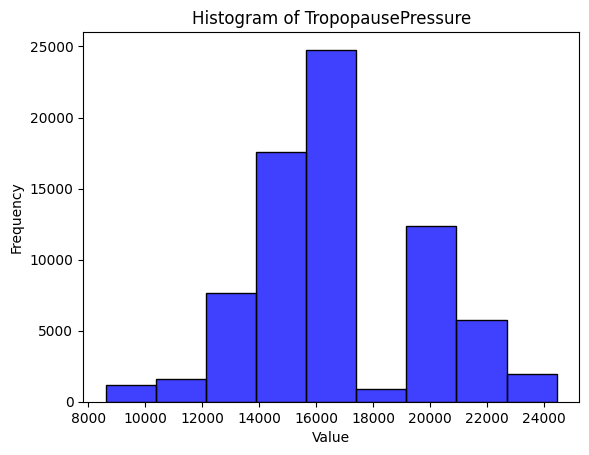

In [5]:
sns.histplot(train["TropopausePressure"], bins=9, kde=False, color='blue', edgecolor='black')

# Customize labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of TropopausePressure')

# Display the plot
plt.show()

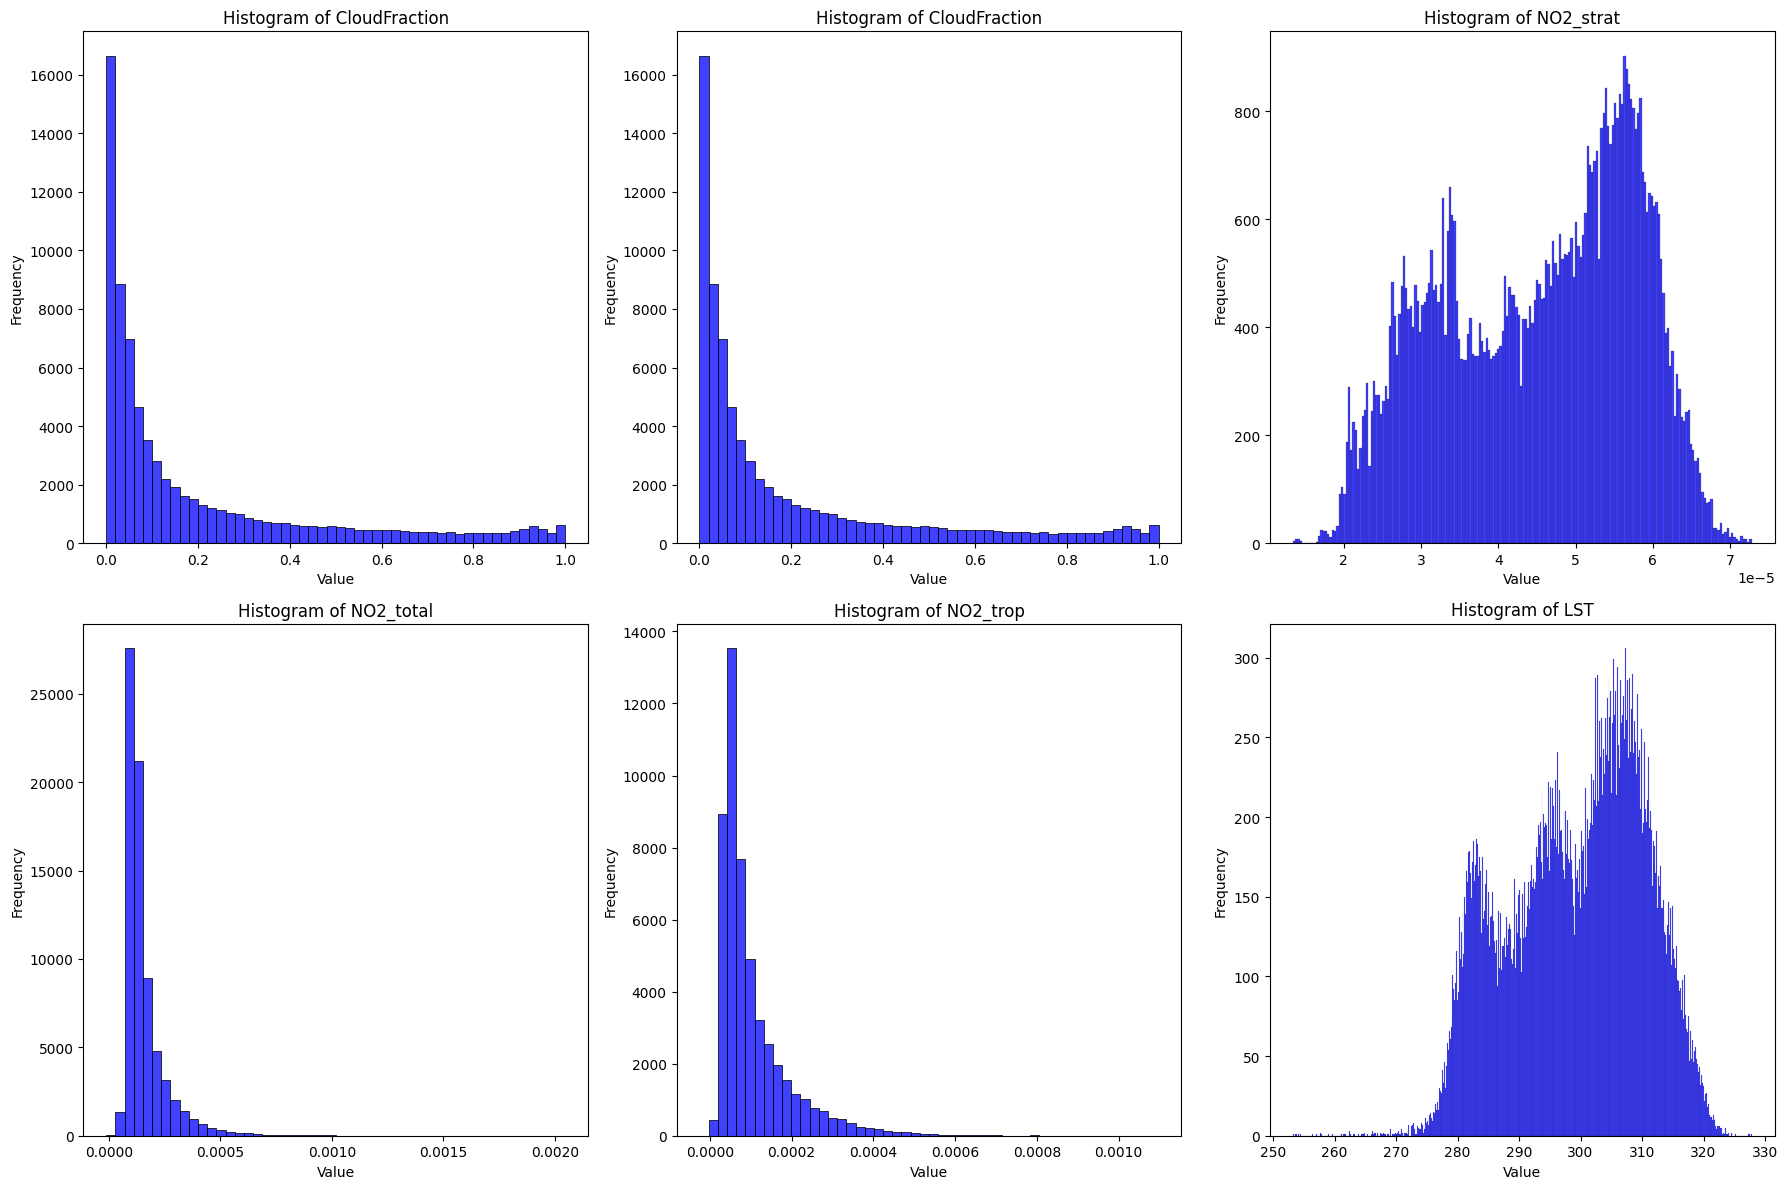

In [6]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot the first histogram in the first subplot
sns.histplot(train["CloudFraction"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[0, 0])
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Histogram of CloudFraction')

# Plot the second histogram in the second subplot
sns.histplot(train["CloudFraction"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[0, 1])
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of CloudFraction')

# Plot the third histogram in the third subplot
sns.histplot(train["NO2_strat"], bins=200, kde=False, color='blue', edgecolor='black', ax=axes[0, 2])
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Histogram of NO2_strat')

# Plot the fourth histogram in the fourth subplot
sns.histplot(train["NO2_total"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram of NO2_total')

# Plot the fifth histogram in the fifth subplot
sns.histplot(train["NO2_trop"], bins=50, kde=False, color='blue', edgecolor='black', ax=axes[1, 1])
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of NO2_trop')

# Plot the sixth histogram in the sixth subplot
sns.histplot(train["LST"], bins=500, kde=False, color='blue', edgecolor='black', ax=axes[1, 2])
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Histogram of LST')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## Let's use the date feature for a plot

In [7]:
train['Date'] = pd.to_datetime(train['Date'])

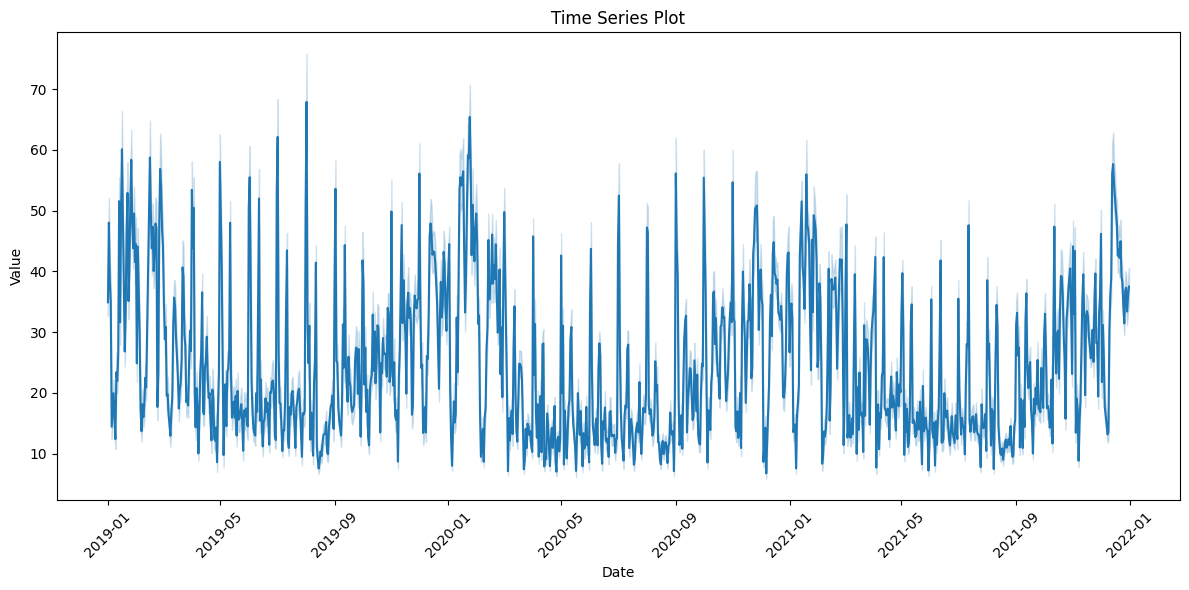

In [8]:
plt.figure(figsize=(12, 6))

# Plot using Seaborn's lineplot
sns.lineplot(x = train["Date"], y="GT_NO2", data=train)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')

# Display the plot
plt.tight_layout()
plt.show()

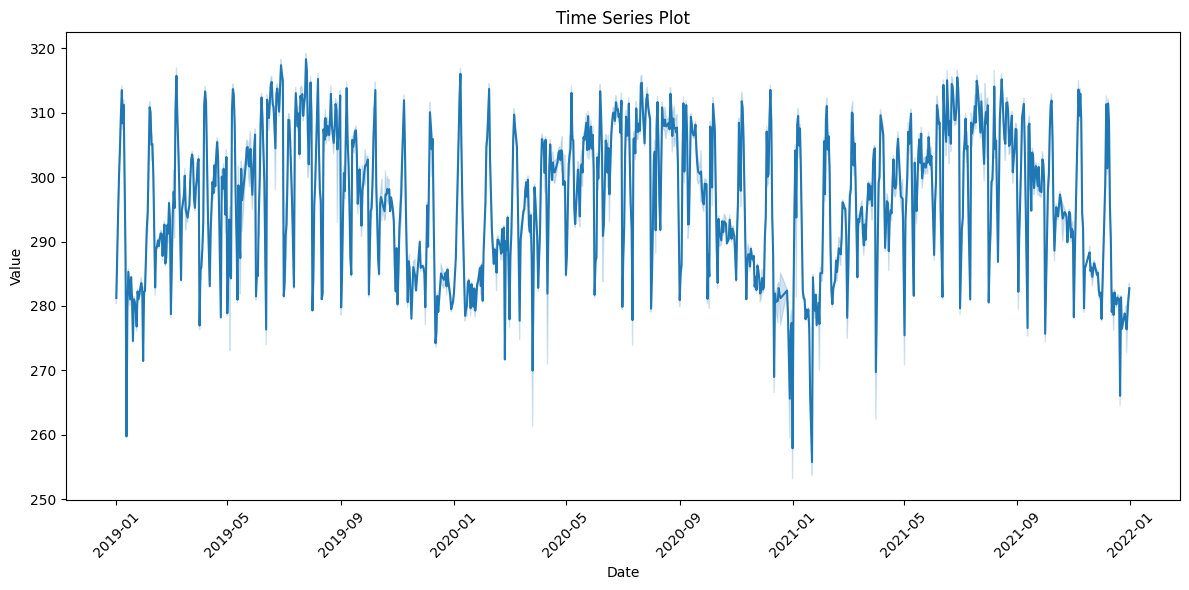

In [9]:
plt.figure(figsize=(12, 6))
# Plot using Seaborn's lineplot
sns.lineplot(x = train["Date"], y="LST", data=train)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')

# Display the plot
plt.tight_layout()
plt.show()

# Now some Preprocessing

In [10]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def Prep(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    numeric_columns = df.select_dtypes(include=['number']).columns
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(), inplace=True)
    
    # Define the rolling window size (e.g., 3 days)
    window_size = 3

    # Exclude the 'Date' column from rolling calculations
    rolling_numeric_columns = df[numeric_columns]
    
    # Calculate rolling mean for each numeric feature
    df_rolling_mean = rolling_numeric_columns.rolling(window=window_size).mean()

    # Calculate rolling standard deviation for each numeric feature
    df_rolling_std = rolling_numeric_columns.rolling(window=window_size).std()

    # Rename the columns to indicate they are rolling statistics
    df_rolling_mean.columns = [f'{col}_rolling_mean' for col in df_rolling_mean.columns]
    df_rolling_std.columns = [f'{col}_rolling_std' for col in df_rolling_std.columns]

    # Concatenate the rolling statistics with the original dataframe
    df_combined = pd.concat([df, df_rolling_mean, df_rolling_std], axis=1)

    # Extract year, month, and day into separate columns
    df_combined['year'] = df_combined['Date'].dt.year
    df_combined['month'] = df_combined['Date'].dt.month
    df_combined['day'] = df_combined['Date'].dt.day

    # Additional feature engineering
    if 'NO2_trop' in df_combined.columns and 'NO2_strat' in df_combined.columns:
        df_combined["NO2_Ratio"] = df_combined["NO2_trop"] / df_combined["NO2_strat"]
    else:
        df_combined["NO2_Ratio"] = 0
        
    if 'NO2_strat' in df_combined.columns and 'NO2_total' in df_combined.columns and 'NO2_trop' in df_combined.columns:
        df_combined["SUM"] = df_combined["NO2_strat"] + df_combined["NO2_total"] + df_combined["NO2_trop"]
    else:
        df_combined["SUM"] = 0
        
    if 'LST' in df_combined.columns:
        df_combined["LSTsqr"] = df_combined["LST"] ** 2
    else:
        df_combined["LSTsqr"] = 0
        
    if 'Precipitation' in df_combined.columns:
        df_combined["Precipitationsqr"] = df_combined["Precipitation"] ** 2
    else:
        df_combined["Precipitationsqr"] = 0
    
    df_combined.fillna(value = 0, inplace=True)
    
    return df_combined

# Assuming `train` and `test` are your DataFrames
train_prepped = Prep(train)
test_prepped = Prep(test)


### The modeling wasn't published here if this notebook get some interest and feedback I might publish the modeling and optimization and extra plots in a future notebook 
$$I \ hope \ this \ help \ you \ if \ you \ have \ questions \ or \ feedback \ just \ comment$$